### Train a wave detector using a simplified U-net architecture

https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py



In [ ]:
from surfbreak.base_models import WaveUnet
from torchsummary import summary

The plan is to input a 2-channel image with:
1. the fist channel the greyscale video intensity
2. second channel the delta intensity between this and the next timestep

In [ ]:
model = WaveUnet(n_class=1, n_input_channels=2)
model = model.to('cuda')
# Requires input x,y dimensions be evenly divisible by 4
summary(model, input_size=(2, 128, 256))  # NOTE: This might need batch-norm to work properly?  investigate later.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 256]           1,216
              ReLU-2         [-1, 64, 128, 256]               0
         MaxPool2d-3          [-1, 64, 64, 128]               0
            Conv2d-4         [-1, 128, 64, 128]          73,856
              ReLU-5         [-1, 128, 64, 128]               0
         MaxPool2d-6          [-1, 128, 32, 64]               0
            Conv2d-7          [-1, 256, 32, 64]         295,168
              ReLU-8          [-1, 256, 32, 64]               0
          Upsample-9         [-1, 256, 64, 128]               0
           Conv2d-10         [-1, 128, 64, 128]         442,496
             ReLU-11         [-1, 128, 64, 128]               0
         Upsample-12        [-1, 128, 128, 256]               0
           Conv2d-13         [-1, 64, 128, 256]         110,656
             ReLU-14         [-1, 64, 1

Define the training dataset and lightning model class

In [ ]:
video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'
from surfbreak.datasets import WavefrontSupervisionDataset, MaskedCNNWavefrontDataset
wfs_dataset = WavefrontSupervisionDataset(video_filepath, ydim=128, timerange=(0,10),
                                          time_chunk_duration_s=1, time_chunk_stride_s=1)

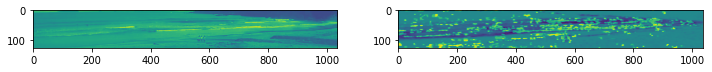

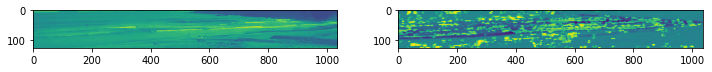

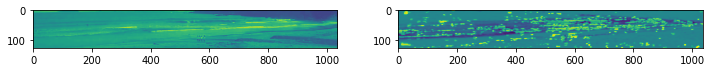

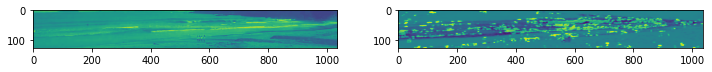

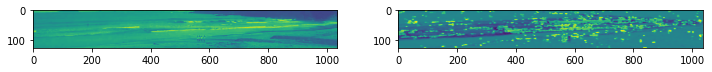

In [ ]:
import matplotlib.pyplot as plt
_, gt = wfs_dataset[0]
for t_idx in range(5):
    fig, axes = plt.subplots(ncols=2, figsize=(12,2))
    axes[0].imshow(gt['video_txy'][t_idx].T)
    axes[1].imshow(gt['wavefronts_txy'][t_idx].T)

torch.Size([2, 1036, 128]) torch.Size([1, 1036, 128])


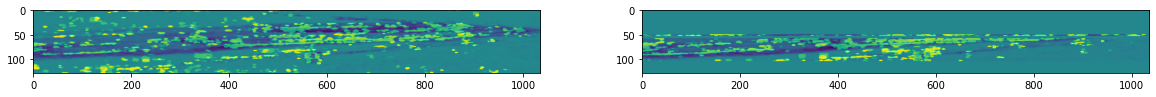

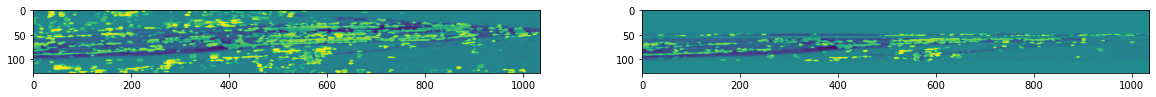

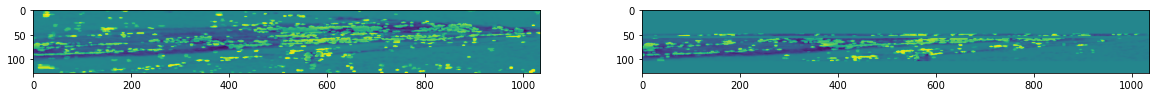

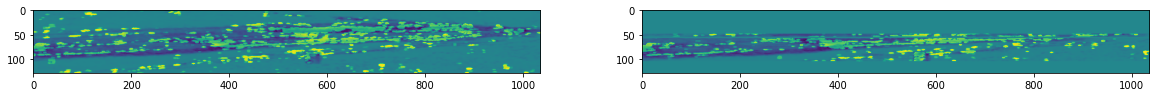

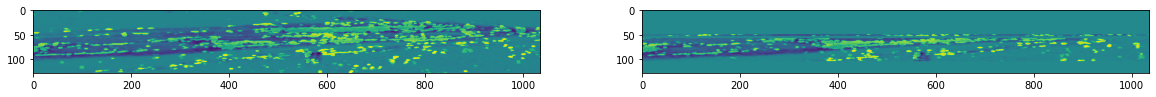

In [ ]:
cnn_dataset = MaskedCNNWavefrontDataset(wfs_dataset)
model_in, gt = cnn_dataset[0]
print(model_in.shape, gt.shape)
import matplotlib.pyplot as plt
for t_idx in range(5):
    model_in, gt = cnn_dataset[t_idx]    
    fig, axes = plt.subplots(ncols=2, figsize=(20,2))
    axes[0].imshow(model_in[1].T)
    axes[1].imshow(gt[0].T)

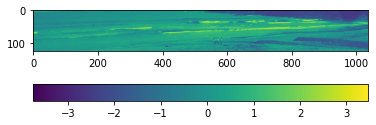

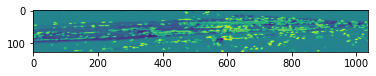

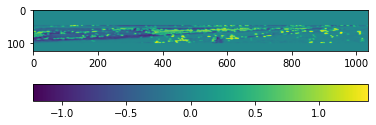

In [ ]:
plt.imshow(model_in[0].T)
plt.colorbar(orientation='horizontal'); plt.show()
plt.imshow(model_in[1].T); plt.show()
plt.imshow(gt[0].T)
plt.colorbar(orientation='horizontal'); plt.show()

### Actually try training it!

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet, LitWaveCNN

pl.seed_everything(42)

tb_logger = pl.loggers.TensorBoardLogger('../logs/', name="wavecnn")
trainer = pl.Trainer(logger=tb_logger, #limit_val_batches=15,
                     max_epochs=20, 
                     gpus=1 if torch.cuda.is_available() else None,)

wavecnn_model = LitWaveCNN(video_filepath='../data/shirahama_1590387334_SURF-93cm.ts', 
                           learning_rate=1e-4, timerange=(0,4*60), val_timerange=(4*60,5*60))
    
trainer.fit(wavecnn_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  


  | Name  | Type     | Params | In sizes         | Out sizes       
-------------------------------------------------------------------------
0 | model | WaveUnet | 923 K  | [1, 2, 128, 256] | [1, 1, 128, 256]


1

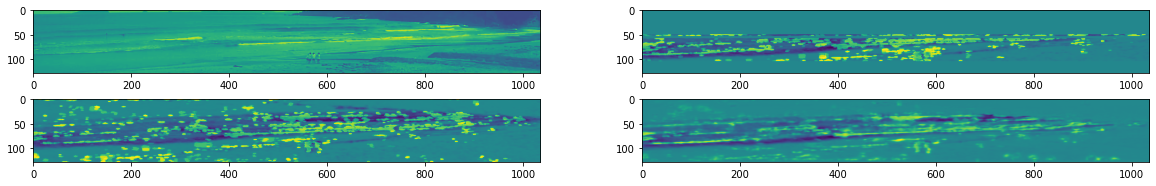

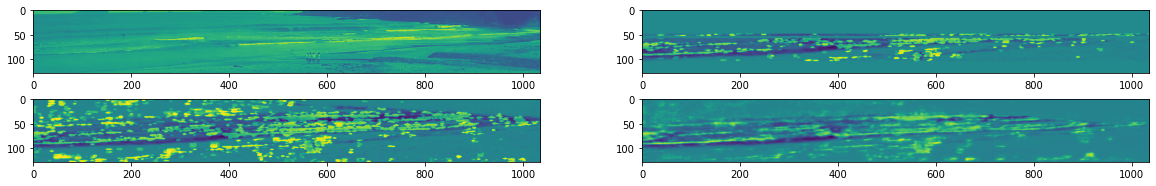

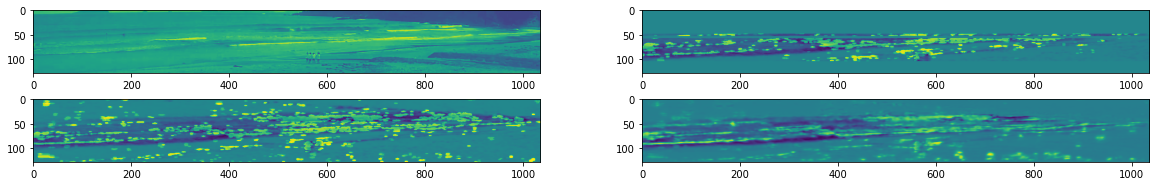

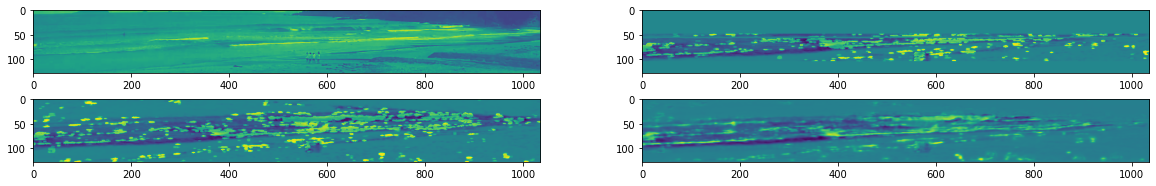

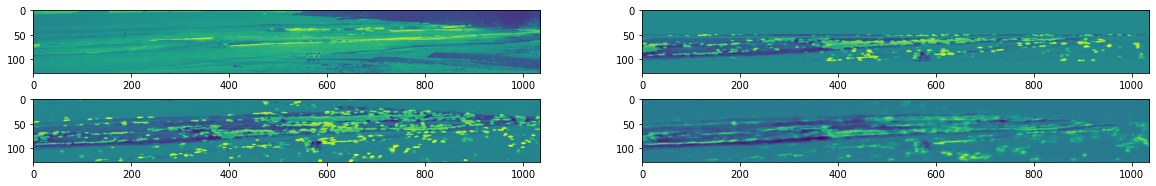

In [ ]:
video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'
from surfbreak.datasets import WavefrontSupervisionDataset, MaskedCNNWavefrontDataset
wfs_dataset = WavefrontSupervisionDataset(video_filepath, ydim=128, timerange=(0,10),
                                          time_chunk_duration_s=1, time_chunk_stride_s=1)
cnn_dataset = MaskedCNNWavefrontDataset(wfs_dataset)


import matplotlib.pyplot as plt
for t_idx in range(5):
    model_in, gt = cnn_dataset[t_idx]
    fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(20,3))
    inferred_wavefronts = wavecnn_model(model_in[None,...].cuda()).detach().cpu() 
    axes[0][0].imshow(model_in[0].T)
    axes[1][0].imshow(model_in[1].T)
    axes[0][1].imshow(gt[0].T)
    axes[1][1].imshow(inferred_wavefronts[0,0].T)
    

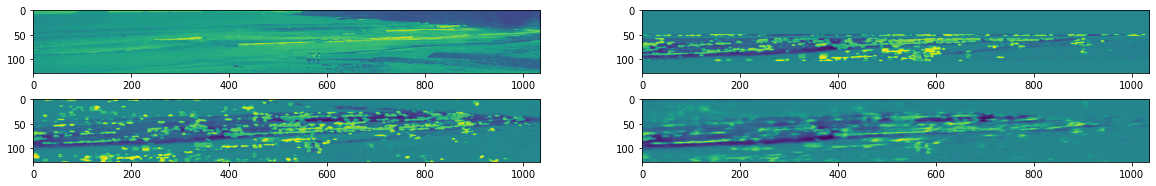

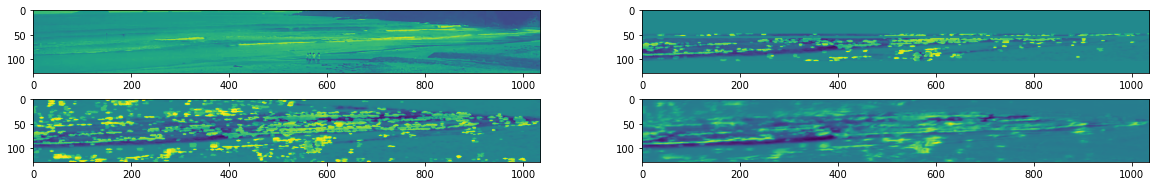

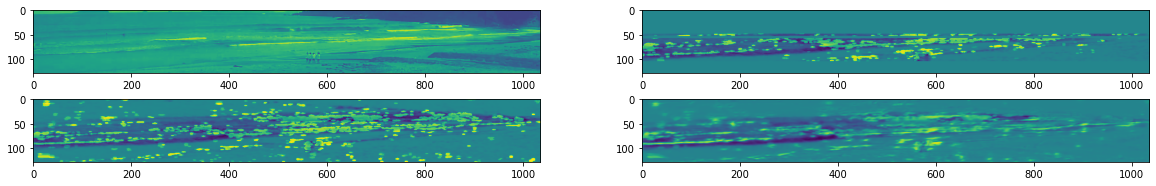

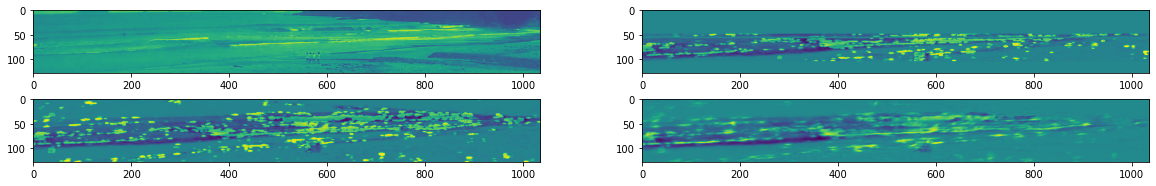

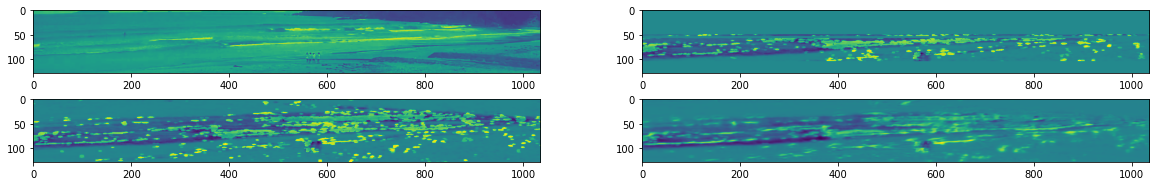

In [ ]:
video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'
from surfbreak.datasets import WavefrontSupervisionDataset, MaskedCNNWavefrontDataset
wfs_dataset = WavefrontSupervisionDataset(video_filepath, ydim=128, timerange=(0,10),
                                          time_chunk_duration_s=1, time_chunk_stride_s=1)
cnn_dataset = MaskedCNNWavefrontDataset(wfs_dataset)


import matplotlib.pyplot as plt
for t_idx in range(5):
    model_in, gt = cnn_dataset[t_idx]
    fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(20,3))
    inferred_wavefronts = wavecnn_model(model_in[None,...].cuda()).detach().cpu() 
    axes[0][0].imshow(model_in[0].T)
    axes[1][0].imshow(model_in[1].T)
    axes[0][1].imshow(gt[0].T)
    axes[1][1].imshow(inferred_wavefronts[0,0].T)
    

## Now configure it to load from a checkpoint
And then it can be used!

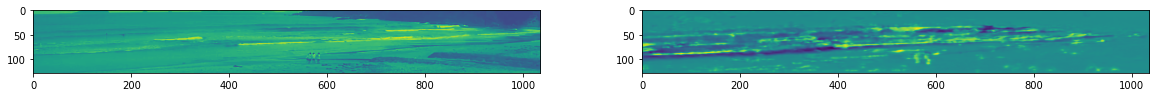

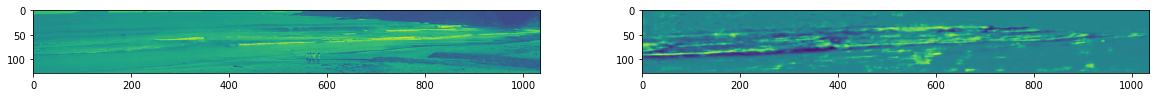

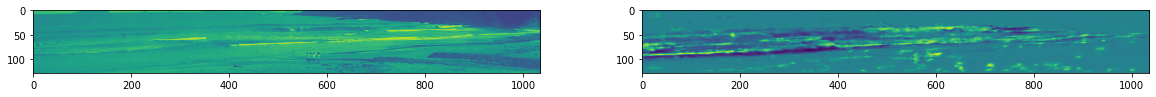

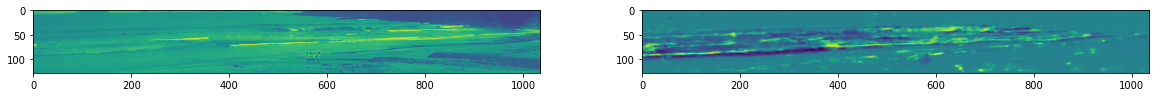

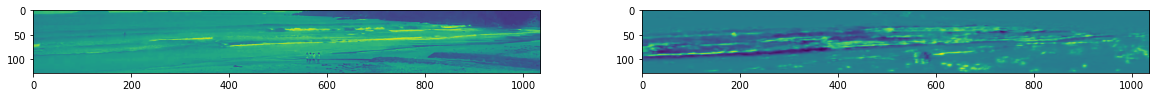

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet, LitWaveCNN
from surfbreak.datasets import WaveformVideoDataset, InferredWaveformDataset,\
                               trim_img_to_nearest_multiple, video_txy_to_wavecnn_array_cxy

video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'

simplecnn_model = LitWaveCNN.load_from_checkpoint('../bestlogs/simplecnn/checkpoints/epoch=18.ckpt')


from surfbreak.datasets import WavefrontSupervisionDataset, MaskedCNNWavefrontDataset
wfs_dataset = WavefrontSupervisionDataset(video_filepath, ydim=128, timerange=(0,10),
                                          time_chunk_duration_s=1, time_chunk_stride_s=1)
cnn_dataset = MaskedCNNWavefrontDataset(wfs_dataset)


import matplotlib.pyplot as plt
for t_idx in range(5):
    model_in, gt = cnn_dataset[t_idx]
    fig, axes = plt.subplots(ncols=2, figsize=(20,3))
    inferred_wavefronts = simplecnn_model(model_in[None,...]).detach()
    axes[0].imshow(model_in[0].T)
    axes[1].imshow(inferred_wavefronts[0,0].T)
    